In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import altair as alt
import igraph
alt.renderers.enable('mimetype')
pm.__version__

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


'5.0.2'

In [4]:
tools = pd.read_csv("../../../datasets/Kline2.csv")
tools

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,8.987197
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.126959
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.472705
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.769956
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.524526


In [9]:
island_distances = pd.read_csv("../../../datasets/island_matrix.csv")
island_distances = island_distances.set_index(island_distances.columns.values)
island_distances

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884
Trobriand,2.036,2.007,1.708,2.462,3.219,0.000,1.801,0.850,3.893,6.653
Chuuk,3.178,2.877,2.588,1.555,4.027,1.801,0.000,1.213,4.789,5.787
Manus,2.794,2.670,2.356,1.616,3.906,0.850,1.213,0.000,4.622,6.722
Tonga,1.860,1.965,2.279,6.136,0.763,3.893,4.789,4.622,0.000,5.037
Hawaii,5.678,5.283,5.401,7.178,4.884,6.653,5.787,6.722,5.037,0.000


In [12]:
society_idx, societies = pd.factorize(tools['culture'])

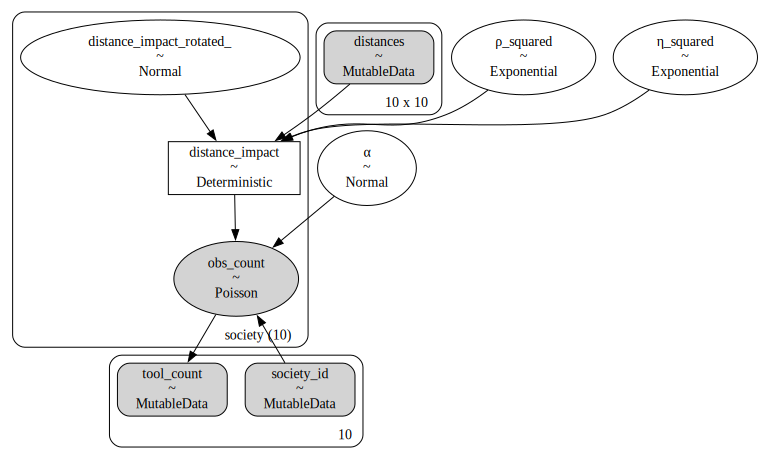

In [32]:
coords = {
    'society': societies
}


with pm.Model(coords=coords) as tools_model:

    #data
    soc_idx = pm.MutableData("society_id", society_idx, coords='society')
    count = pm.MutableData("tool_count", tools['total_tools'], coords='society')
    distances = pm.MutableData("distances", island_distances)


    #baseline
    α = pm.Normal("α", 3, 0.5)
    η = pm.Exponential("η_squared", 2)
    ρ = pm.Exponential("ρ_squared", 2)


    #covariance function is parameterized with extra 2 in pyMC 
    cov_func = η * pm.gp.cov.ExpQuad(input_dim=10, ls= ρ)
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the distances
    S = gp.prior("distance_impact", X=distances, dims='society')

    λ = pm.math.exp(α + S[soc_idx])

    pm.Poisson('obs_count', mu=λ, observed=count, dims='society')

pm.model_to_graphviz(tools_model)

In [47]:
with tools_model:
    tools_trace = sampling_jax.sample_blackjax_nuts(draws=4000)
    #tools_trace = pm.sample()

Compiling...
Compilation time =  0:00:02.655948
Sampling...
Sampling time =  0:00:05.437881
Transforming variables...
Transformation time =  0:00:02.485113


In [48]:
az.summary(tools_trace, var_names=['~distance_impact_rotated_',])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.430,0.188,3.078,3.794,0.003,0.002,3198.0,3792.0,1.0
η_squared,0.310,0.179,0.066,0.631,0.003,0.002,3608.0,5601.0,1.0
ρ_squared,0.816,0.727,0.000,2.130,0.012,0.009,3765.0,4900.0,1.0
distance_impact[Malekula],-0.677,0.273,-1.215,-0.186,0.004,0.003,6163.0,8275.0,1.0
distance_impact[Tikopia],-0.351,0.263,-0.847,0.146,0.004,0.003,5031.0,6886.0,1.0
distance_impact[Santa Cruz],-0.250,0.254,-0.721,0.233,0.003,0.002,5580.0,7211.0,1.0
distance_impact[Yap],0.295,0.229,-0.132,0.732,0.004,0.002,4235.0,5430.0,1.0
distance_impact[Lau Fiji],0.053,0.237,-0.377,0.513,0.004,0.003,4337.0,5370.0,1.0
distance_impact[Trobriand],-0.418,0.257,-0.899,0.075,0.003,0.002,5701.0,7024.0,1.0
distance_impact[Chuuk],0.224,0.232,-0.192,0.681,0.003,0.002,4675.0,6205.0,1.0


<Axes: >

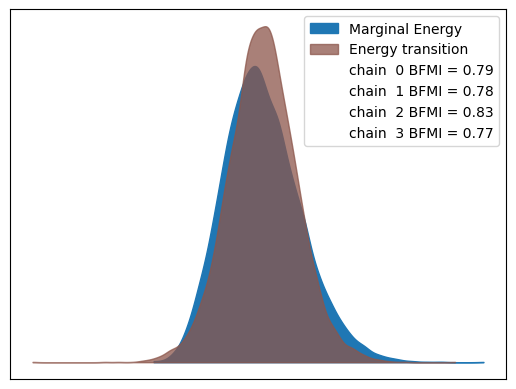

In [50]:
az.plot_energy(tools_trace)

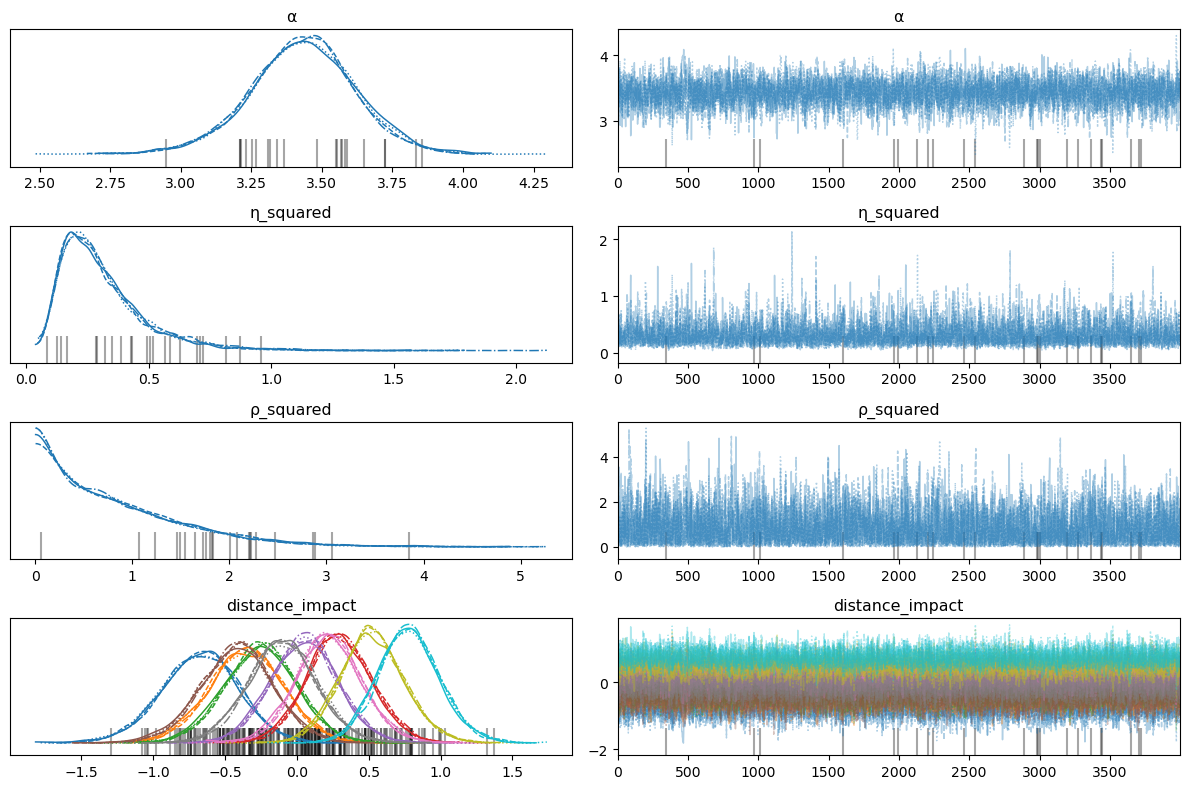

In [49]:
az.plot_trace(tools_trace, var_names=['~distance_impact_rotated_',])
plt.tight_layout()
plt.show()

## Tools model stratified by population size